# Attention is all you Need 

### Vanilla Transformer
此架构的第一件事是它遵循编码器-解码器架构（即：序列到序列）。

![Transformer Architecture](docs/imgs/vanila_transformer.png "Transformer Architecture")

该模型实际上有 3 个端口：
* 编码器输入端口
* 解​​码器输入端口
* 模型的输出端口

该模型的没有使用 RNN（LSTM、GRU），基本上由以下部分组成：
* FC 层
* 层规范
* 加法和乘法运算
* Softmax 和 Relu 激活

这与之前的带注意力机制的 Sequence-to-Sequence 模型不同。



### 编码器解码器堆栈

编码器/解码器都是一些模块的堆叠（论文上的大小为 N=6）。实际上，您可以使用其他大小。

![Encoder Decoder Stack](docs/imgs/encoder_decoder_stack.png "Encoder Decoder Stack")


### 输入/输出嵌入
与 Seq2Seq 架构类似，嵌入层将使用训练数据来找到词汇的最佳表示（即 Word2Vec）。
换句话说，该层将使用 [embedding algorithm](https://medium.com/deeper-learning/glossary-of-deep-learning-word-embedding-f90c3cec34ca).

![Embedding](docs/imgs/embedding.png "Embedding")

### 位置编码
Transformer 架构的最大优势之一是我们可以独立地并行计算事物，因为我们将整个序列提供给模型，在进行注意力机制的计算时与序列的顺序的没有关系的，因此需要额外引入位置编码帮助模型理解序列的顺序信息

![Positional Encoding](docs/imgs/pos_encoding.png "Positional Encoding")

### 注意力机制的计算流程


#### 相似性计算
1. 注意力需要做的第一件事是找到查询和键之间的相似性，这是通过得分函数完成的，该函数为输入序列的每个输入元素返回 n 个分数。

$$
a_i = \alpha(\mathbf q, \mathbf k_i)
$$

不同的得分函数$\alpha$将决定您创建的注意力类型

在Transformer中，我们使用点积注意力的变体。

2. 得分函数生成分数后，我们使用 softmax 层将这些分数转换为概率：

$$
b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n)。
$$

3. 然后将这些概率（有时称为注意力权重）应用于值，这里的“n”是的键/值对的数量。

$$
\mathbf o = \sum_{i=1}^n b_i \mathbf v_i。
$$

##### 点积注意力
在这个注意力中，我们将q向量和k向量设置的具有相同的维度，并使用内积来计算查询/键对的相似程度。

$$
\mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

如上所述，这种类型的注意力用于 Transformer 架构，略有不同的是，我们将整个内积除以 $\sqrt{d_k}$，以使分数对输入大小（时间步数或序列长度）不太敏感。
[详解](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) 


### 多头注意力


![Transformer Main Blocks](docs/imgs/IntroTransformer.png "Transformer Main Blocks")




### Position Wise (Feed Forward) Layer
前馈网络（Feed Forward Layer, FFL）在Transformer中的作用可以归纳为以下几点：

1. **特征变换**：

前馈网络对每个位置的输入特征进行独立的非线性变换。尽管注意力机制能够捕捉序列中不同位置之间的依赖关系，但前馈网络则专注于对每个位置上的特征进行丰富和变换，提升特征表达能力。

2. **增加模型的表达能力**：

FFL通常由两个线性变换和一个非线性激活函数（如ReLU）组成，中间可能会通过改变特征维度来调整模型的参数量和计算量。例如，FFL先将特征维度扩大，然后再缩小回原来的维度，这个过程有助于模型学习更复杂的特征表示。

3. **分离空间和时间的处理**：

在Transformer中，注意力机制负责建模序列中不同位置之间的关系（空间维度），而前馈网络则负责对每个位置的特征进行处理（时间维度）。这种分离使得模型在捕捉长距离依赖关系和特征变换时更加高效。
参数共享与独立处理：



### Add and Norm(LayerNorm)
此层用于组合以下块的输入/输出：
* Multi-Head Attention
* Position Wise Feed Forward

![Add Norm Layer](docs/imgs/add_norm_block.png "Title")

该层在架构上的用途是迫使模型更快地收敛，并允许模型更深。

#### LayerNorm
层归一化是一种类似于批量归一化的归一化方法，不同之处在于均值和方差是沿着最后一个维度（axis=-1）计算的，该维度通常是特征维度。

使用 LayerNorm，统计数据是跨每个特征计算的，并且与其他示例无关。输入之间的独立性意味着每个输入都有不同的归一化操作。考虑到您的数据具有形状 [batch, x sequence, x features]

![BatchNorm vs LayerNorm](docs/imgs/batch_vs_layer_norm.png "Title")

#### Residuals
残差用于使非常深的模型的训练变得更容易，因为残差路径将充当梯度"高速公路"，改善反向传播过程中的梯度消失问题。

![Residuals](docs/imgs/residuals.png "Residuals")

### Generator
这是 Transformer 的最后一层，负责预测解码器输出。
![Generator](docs/imgs/generator.png "Title")


In [27]:
import copy
import math

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
#from torch.utils.tensorboard import SummaryWriter

import utils_transformer as utils
import math, copy, time

import matplotlib.pyplot as plt
print("PyTorch Version: ",torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
num_gpu = torch.cuda.device_count()
print('Number of GPUs Available:', num_gpu)

# # Default directory "runs"
# writer = SummaryWriter()

PyTorch Version:  2.0.1
Device: cuda:0
Number of GPUs Available: 2


#### HyperParameters

In [28]:
batch_size = 2
sequence_length = 6
hidden_size = 16
attention_heads = 8

#### Embeddings
将输入token和输出token转换为维度为 d 的向量。

In [29]:
class Embeddings(nn.Module):  # 定义一个名为Embeddings的类，继承自nn.Module
    def __init__(self, d_model_hidden_size, vocab_size):  # 初始化函数，接收隐藏层大小和词汇表大小作为参数
        super(Embeddings, self).__init__()  # 调用父类的初始化方法
        # vocab_size: 词汇表中的元素数量
        # d_model_hidden_size: 隐藏层的大小
        self.lut = nn.Embedding(vocab_size, d_model_hidden_size)  # 创建一个嵌入层，将词汇表大小和隐藏层大小作为参数
        self.d_model = d_model_hidden_size  # 将隐藏层大小存储在实例变量d_model中

    def forward(self, x):  # 定义前向传播函数，接收输入x
        # 查找嵌入向量，将输入的单词索引转换为对应的嵌入向量
        # 输出形状为 (batch_size, sequence_length, d_model_hidden_size)
        return self.lut(x) * math.sqrt(self.d_model)  # 返回嵌入向量，并乘以隐藏层大小的平方根，以进行缩放


#### Attention
在实践中，我们同时计算一组查询的注意力函数，并将其打包成矩阵 $Q$。 $K$和 $V$也被打包成矩阵 $K$ 和 $V$。我们计算输出矩阵如下：                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

你可能会注意到，在实现上我们有一个 Mask 参数，这个 mask 将用于在解码器上实现 Mask Multi-Head Attention，并使编码器忽略“填充”信息。

In [30]:
# 实现注意力机制（缩放点积注意力）
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)  # 获取query的最后一个维度的大小，通常是嵌入向量的维度
    # 计算注意力得分，通过query和key的转置相乘，然后除以d_k的平方根进行缩放
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:  # 如果提供了掩码
        # 使用掩码填充得分为负无穷大，以避免在softmax中被考虑
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # 对得分应用softmax，沿着最后一个维度进行归一化
    p_attn = F.softmax(scores, dim=-1)
    
    if dropout is not None:  # 如果提供了dropout层
        p_attn = dropout(p_attn)  # 对注意力分布应用dropout
    
    # 计算注意力结果，通过注意力分布p_attn和value相乘
    attention_result = torch.matmul(p_attn, value)
    
    # 返回注意力结果和注意力分布
    return attention_result, p_attn


#### MultiHeaded Attention
多头注意力模块允许我们在不同的表示级别（N）关注同一个概念

In [31]:
class MultiHeadedAttention(nn.Module):  # 定义一个名为MultiHeadedAttention的类，继承自nn.Module
    def __init__(self, h, d_model, dropout=0.1):  # 初始化函数，接收头数h、模型维度d_model和dropout比率作为参数
        "Take in model size and number of heads."  # 简短说明：接收模型大小和头的数量
        super(MultiHeadedAttention, self).__init__()  # 调用父类的初始化方法
        assert d_model % h == 0  # 确保模型维度可以被头数整除
        # 我们假设d_v总是等于d_k
        self.d_k = d_model // h  # 计算每个头的维度
        self.h = h  # 存储头的数量
        self.linears = utils.clones(nn.Linear(d_model, d_model), 4)  # 创建四个线性变换层
        self.attn = None  # 初始化注意力权重
        self.dropout = nn.Dropout(p=dropout)  # 创建dropout层，设置丢弃率
        
    def forward(self, query, key, value, mask=None):  # 定义前向传播函数，接收query、key、value和可选的mask作为参数
        
        if mask is not None:  # 如果提供了掩码
            # 对所有的头应用相同的掩码
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)  # 获取batch的大小
        
        # 1) 在批处理中执行所有线性变换，从d_model => h x d_k
        # query、key和value的原始形状是 [nbatches, seq_len, d_model]
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) 对所有投影向量应用注意力机制
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # 3) 使用view将结果“连接”起来，并应用最终的线性变换
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)  # 返回最后的线性变换结果


#### Position Wise Feed Forward
该层的想法是在输入的不同位置（时间步长）上应用相同的 FC 层

它由两个线性变换组成，中间有一个 ReLU 激活。

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$
例如，如果输入序列 = <x1,x2…xm>，则位置的总大小为 m 。

另一种描述方式是将其描述为两个卷积，内核大小为 1。输入和输出的维数为 $d_{\text{model}}=512$，内层的维数为 $d_{ff}=2048$。

In [32]:
class PositionwiseFeedForward(nn.Module):  # 定义一个名为PositionwiseFeedForward的类，继承自nn.Module
    def __init__(self, d_model, d_ff, dropout=0.1):  # 初始化函数，接收模型维度d_model、前馈网络维度d_ff和dropout比率作为参数
        super(PositionwiseFeedForward, self).__init__()  # 调用父类的初始化方法
        self.w_1 = nn.Linear(d_model, d_ff)  # 定义第一个线性层，将d_model维度映射到d_ff维度
        self.w_2 = nn.Linear(d_ff, d_model)  # 定义第二个线性层，将d_ff维度映射回d_model维度
        self.dropout = nn.Dropout(dropout)  # 创建dropout层，设置丢弃率

    def forward(self, x):  # 定义前向传播函数，接收输入x
        # 对输入x应用第一个线性层，然后应用ReLU激活函数，再应用dropout层，最后应用第二个线性层
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


#### Positional Encoding

##### register_buffer
在PyTorch中，register_buffer函数用于将一个张量注册为模块中的缓冲区。这意味着该张量将成为模块状态的一部分，但不会被视为模型参数，因此在训练期间不会被优化器更新。在给定代码中，它的作用如下：

In [33]:
# 实现非递归神经网络的正弦位置编码
class PositionalEncoding(nn.Module):  # 定义一个名为PositionalEncoding的类，继承自nn.Module
    def __init__(self, d_model, dropout=0, max_len=5000):  # 初始化函数，接收模型维度d_model、dropout比率和最大序列长度max_len作为参数
        super(PositionalEncoding, self).__init__()  # 调用父类的初始化方法
        self.dropout = nn.Dropout(p=dropout)  # 创建dropout层，设置丢弃率
        
        # 在对数空间中计算位置编码
        pe = torch.zeros(max_len, d_model)  # 初始化位置编码矩阵，形状为[max_len, d_model]
        # 将position和div_term转换为浮点数
        position = torch.arange(0., max_len).unsqueeze(1)  # 创建位置序列，并添加一个维度使其形状为[max_len, 1]
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))  # 计算除数项
        
        # 将位置编码矩阵的偶数索引位置设置为sin函数值
        pe[:, 0::2] = torch.sin(position * div_term)
        # 将位置编码矩阵的奇数索引位置设置为cos函数值
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # 添加一个维度，使其形状为[1, max_len, d_model]
        
        # 注册缓冲区，使得在训练期间位置编码矩阵保持不变
        self.register_buffer('pe', pe)
        
    def forward(self, x):  # 定义前向传播函数，接收输入x
        # 将位置编码添加到输入中
        x = x + self.pe[:, :x.size(1)]  # 将位置编码矩阵的前x.size(1)行添加到输入x中
        return self.dropout(x)  # 对结果应用dropout层并返回


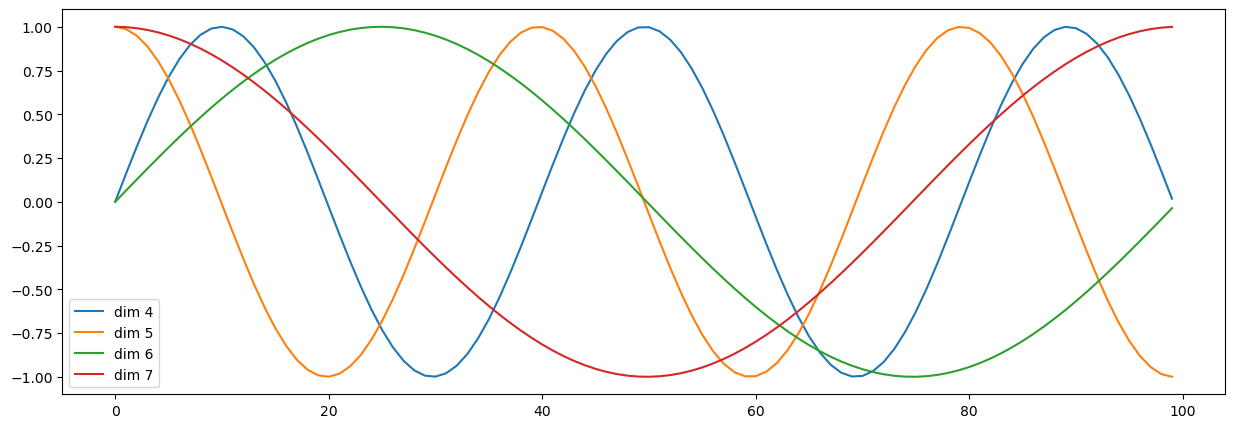

In [34]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

#### Generator (Output Layer)
Apply a linear layer (FC) and softmax.

In [35]:
class Generator(nn.Module):
    def __init__(self, decoder_output_size, output_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(decoder_output_size, output_size)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [36]:
class EncoderDecoder(nn.Module):
    """
    一个标准的编码器-解码器架构。这是该模型和许多其他模型的基础。
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder  # 编码器模块
        self.decoder = decoder  # 解码器模块
        self.src_embed = src_embed  # 源数据嵌入层
        self.tgt_embed = tgt_embed  # 目标数据嵌入层
        self.generator = generator  # 生成器模块，用于生成最终输出
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        接收并处理带有掩码的源序列和目标序列。
        """
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        """
        使用编码器对源序列进行编码。
        src: 源序列输入
        src_mask: 源序列掩码
        """
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        """
        使用解码器对目标序列进行解码。
        memory: 编码器输出的记忆
        src_mask: 源序列掩码
        tgt: 目标序列输入
        tgt_mask: 目标序列掩码
        """
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [37]:
class Encoder(nn.Module):
    "核心编码器是N层的堆叠"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = utils.clones(layer, N)  # 克隆N个相同的层，组成编码器的堆叠
        self.norm = LayerNorm(layer.size)  # 初始化层归一化模块，归一化层的尺寸与输入层相同
        
    def forward(self, x, mask):
        "依次通过每一层处理输入（和掩码）"
        for layer in self.layers:
            x = layer(x, mask)  # 依次通过每一层，将输入x和掩码mask传递给每一层
        return self.norm(x)  # 返回归一化后的输出


In [38]:
class LayerNorm(nn.Module):
    "构建一个层归一化模块（详细信息请参见引用）"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))  # 初始化缩放参数a_2，初始值为全1
        self.b_2 = nn.Parameter(torch.zeros(features))  # 初始化平移参数b_2，初始值为全0
        self.eps = eps  # 设置一个小常数eps，用于数值稳定性

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)  # 计算输入x在最后一个维度上的均值，保持维度不变
        std = x.std(-1, keepdim=True)  # 计算输入x在最后一个维度上的标准差，保持维度不变
        # 使用均值和标准差进行归一化，然后应用缩放参数a_2和平移参数b_2
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


In [39]:
class SublayerConnection(nn.Module):
    """
    一个残差连接，后跟层归一化。
    注意，为了代码简洁，归一化是首先应用的，而不是最后。
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)  # 初始化层归一化模块，尺寸为size
        self.dropout = nn.Dropout(dropout)  # 初始化dropout层，设置丢弃率

    def forward(self, x, sublayer):
        "对任何具有相同尺寸的子层应用残差连接。"
        # 对输入x先进行归一化，然后传入子层sublayer进行处理，接着应用dropout，最后加上原始输入x实现残差连接
        return x + self.dropout(sublayer(self.norm(x)))


In [40]:
class EncoderLayer(nn.Module):
    "编码器由自注意力机制和前馈网络组成（如下所定义）"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn  # 自注意力机制模块
        self.feed_forward = feed_forward  # 前馈网络模块
        self.sublayer = utils.clones(SublayerConnection(size, dropout), 2)  # 克隆两个子层连接模块
        self.size = size  # 层的大小

    def forward(self, x, mask):
        "按照图1（左侧）的连接方式进行处理。"
        # 先通过第一个子层连接模块，其中子层是自注意力机制
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # 再通过第二个子层连接模块，其中子层是前馈网络
        return self.sublayer[1](x, self.feed_forward)


In [41]:
class Decoder(nn.Module):
    "具有掩码的通用N层解码器。"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = utils.clones(layer, N)  # 克隆N个相同的解码器层
        self.norm = LayerNorm(layer.size)  # 初始化层归一化

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        前向传播函数。
        x: 目标序列输入
        memory: 编码器的输出
        src_mask: 源序列掩码
        tgt_mask: 目标序列掩码
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)  # 依次通过每一层解码器
        return self.norm(x)  # 最后进行层归一化

In [42]:
class DecoderLayer(nn.Module):

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size  # 解码器层的尺寸
        self.self_attn = self_attn  # 自注意力机制层
        self.src_attn = src_attn  # 源注意力机制层
        self.feed_forward = feed_forward  # 前馈神经网络层
        self.sublayer = utils.clones(SublayerConnection(size, dropout), 3)  # 克隆三个子层连接（残差连接+层归一化）

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        x: 目标序列输入
        memory: 编码器的输出
        src_mask: 源序列掩码
        tgt_mask: 目标序列掩码
        """
        m = memory  # 编码器输出的记忆
        # 首先通过第一个子层连接模块，其中子层是自注意力机制
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 然后通过第二个子层连接模块，其中子层是源注意力机制
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # 最后通过第三个子层连接模块，其中子层是前馈神经网络
        return self.sublayer[2](x, self.feed_forward)


In [43]:
# 辅助函数：根据超参数构建模型。
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy  # 深拷贝函数，用于复制模块
    attn = MultiHeadedAttention(h, d_model)  # 多头注意力机制，h为头数，d_model为模型维度
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)  # 位置前馈神经网络
    position = PositionalEncoding(d_model, dropout)  # 位置编码
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),  # 编码器，由N层编码器层组成
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),  # 解码器，由N层解码器层组成
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),  # 源数据嵌入层，包含嵌入和位置编码
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),  # 目标数据嵌入层，包含嵌入和位置编码
        Generator(d_model, tgt_vocab))  # 生成器模块，用于生成最终输出
    
    # 这在他们的代码中很重要。
    # 使用Glorot / fan_avg初始化参数。
    for p in model.parameters():
        if p.dim() > 1:  # 仅对多维参数进行初始化
            nn.init.xavier_uniform_(p)  # 使用xavier_uniform_进行参数初始化
    return model  # 返回构建好的模型


In [44]:
def run_epoch(data_iter, model, loss_compute):
    "标准训练和日志记录函数"
    start = time.time()  # 记录开始时间
    total_tokens = 0  # 总token数初始化为0
    total_loss = 0  # 总损失初始化为0
    tokens = 0  # 当前处理的token数初始化为0
    for i, batch in enumerate(data_iter):  # 遍历数据迭代器中的每个批次
        # 调用模型的前向传播函数，计算输出
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        # 计算损失
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss.detach().numpy()  # 累加损失
        total_tokens += batch.ntokens.numpy()  # 累加总token数
        tokens += batch.ntokens.numpy()  # 累加当前处理的token数
        if i % 50 == 1:  # 每50步打印一次日志
            elapsed = time.time() - start  # 计算经过的时间
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss.detach().numpy() / batch.ntokens.numpy(), tokens / elapsed))  # 打印步骤、损失和每秒处理的token数
            start = time.time()  # 重置开始时间
            tokens = 0  # 重置当前处理的token数
    return total_loss / total_tokens  # 返回平均损失


In [45]:
class NoamOpt:
    "实现学习率调度的优化器封装。"
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer  # 被封装的优化器
        self._step = 0  # 当前步数初始化为0
        self.warmup = warmup  # 预热步数
        self.factor = factor  # 学习率因子
        self.model_size = model_size  # 模型大小
        self._rate = 0  # 当前学习率初始化为0
        
    def step(self):
        "更新参数和学习率"
        self._step += 1  # 步数加1
        rate = self.rate()  # 计算当前学习率
        for p in self.optimizer.param_groups:  # 更新优化器中的学习率
            p['lr'] = rate
        self._rate = rate  # 更新当前学习率
        self.optimizer.step()  # 执行优化器的参数更新
        
    def rate(self, step=None):
        "计算学习率"
        if step is None:  # 如果没有传入步数，则使用当前步数
            step = self._step
        # 根据公式计算学习率
        return self.factor * (self.model_size ** (-0.5) * 
                              min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    "获取标准的NoamOpt优化器"
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                   torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))


In [46]:
class SimpleLossCompute:
    "一个简单的损失计算和训练函数。"
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator  # 生成器模块，用于生成最终输出
        self.criterion = criterion  # 损失函数，用于计算损失
        self.opt = opt  # 优化器，默认为None
        
    def __call__(self, x, y, norm):
        x = self.generator(x)  # 通过生成器生成输出
        # 计算损失，将x和y展平后传入损失函数，并除以规范化因子norm
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()  # 反向传播计算梯度
        if self.opt is not None:  # 如果提供了优化器
            self.opt.step()  # 执行优化器的参数更新
            self.opt.optimizer.zero_grad()  # 清除优化器的梯度
        return loss.item() * norm  # 返回计算的损失值乘以规范化因子


In [47]:
# 训练简单的复制任务。
V = 11  # 词汇表大小
criterion = utils.LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)  # 标签平滑损失函数
model = make_model(V, V, N=2)  # 创建模型，使用2层编码器和解码器
# 创建Noam优化器，使用Adam优化算法，学习率由NoamOpt控制
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400, 
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):  # 训练10个epoch
    model.train()  # 将模型设置为训练模式
    # 训练模型，使用数据生成器生成训练数据，调用run_epoch函数进行训练
    run_epoch(utils.data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    
    model.eval()  # 将模型设置为评估模式
    # 评估模型，使用数据生成器生成验证数据，调用run_epoch函数进行评估
    print(run_epoch(utils.data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))


Epoch Step: 1 Loss: 3.026610 Tokens per Sec: 1612.912391
Epoch Step: 1 Loss: 1.804165 Tokens per Sec: 2967.053676
1.828472742151331
Epoch Step: 1 Loss: 2.015527 Tokens per Sec: 1789.723844
Epoch Step: 1 Loss: 1.568241 Tokens per Sec: 2871.339598
1.5776194932725693
Epoch Step: 1 Loss: 1.744115 Tokens per Sec: 1770.492800
Epoch Step: 1 Loss: 1.332670 Tokens per Sec: 2988.791538
1.3441270164207175
Epoch Step: 1 Loss: 1.575520 Tokens per Sec: 1783.563545
Epoch Step: 1 Loss: 1.337746 Tokens per Sec: 2925.839008
1.3114304154007523
Epoch Step: 1 Loss: 1.318167 Tokens per Sec: 1764.710040
Epoch Step: 1 Loss: 1.054011 Tokens per Sec: 2927.022505
1.0951146782769097
Epoch Step: 1 Loss: 1.165440 Tokens per Sec: 1787.245317
Epoch Step: 1 Loss: 0.883428 Tokens per Sec: 2941.757944
0.7873247386791088
Epoch Step: 1 Loss: 0.840193 Tokens per Sec: 1782.174168
Epoch Step: 1 Loss: 0.462099 Tokens per Sec: 2983.433368
0.47967316804108795
Epoch Step: 1 Loss: 0.580436 Tokens per Sec: 1808.685142
Epoch Step: 

In [48]:
def greedy_decode(model, src, max_len, start_symbol):
    # 将模型设置为评估模式
    model.eval()
    
    # 对完整的输入序列运行编码器
    memory = model.encode(src, None)
    
    # 形状: (batch, sequence_size)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    print('Initial ys shape:', ys.shape)
    
    # 迭代生成最大序列长度
    for i in range(max_len-1):        
        # 避免解码器自注意力机制关注未来的位置
        out_mask = utils.subsequent_mask(ys.size(1))        
        
        # 注意我们将过去的输出序列提供给解码器
        # 编码器掩码在训练过程中用于填充
        out = model.decode(memory, None, ys, out_mask)        
        
        # 获取下一个单词/字符的概率分布（运行Softmax）
        prob = model.generator(out[:, -1])
        
        # 贪婪地选择下一个单词/字符
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]        
        # 将输出拼接
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)        
    return ys

src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
print('Output:', greedy_decode(model, src, max_len=10, start_symbol=1).numpy())


Initial ys shape: torch.Size([1, 1])
Output: [[ 1  2  3  4  5  6  7  8  9 10]]


In [49]:
batch = next(iter(utils.data_gen(5, 2, 1)))

In [50]:
batch.src

tensor([[1, 1, 4, 4, 2, 3, 1, 1, 4, 1],
        [1, 4, 3, 4, 1, 3, 4, 1, 4, 3]], dtype=torch.int32)

In [51]:
batch.trg

tensor([[1, 1, 4, 4, 2, 3, 1, 1, 4],
        [1, 4, 3, 4, 1, 3, 4, 1, 4]], dtype=torch.int32)

In [52]:
batch.trg_mask

tensor([[[ True, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True]],

        [[ True, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True